In [1]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tfk  = tf .keras
tfkl = tfk.layers

from sklearn.datasets import make_moons, make_classification
from sklearn.decomposition import PCA
from tqdm import tqdm

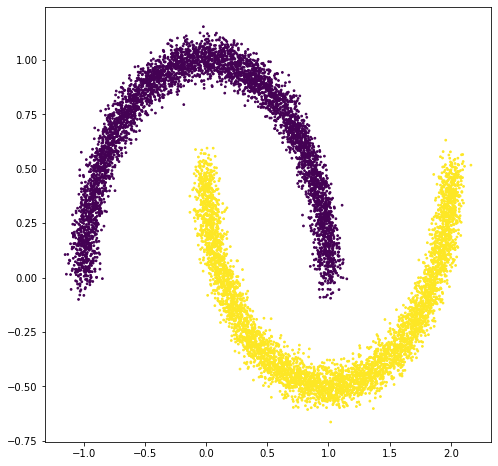

In [2]:
X, Y = make_moons(n_samples = 10000, noise = 0.05)
plt.figure(figsize = (8, 8))
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = Y,
    cmap = 'viridis',
    s = 3,
)
plt.show()

In [3]:
clf = tfk.Sequential([
    tfkl.InputLayer(2),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(1, activation = 'sigmoid')
])
clf.compile(
    loss = 'binary_crossentropy',
    metrics = [tfk.metrics.AUC()],
    optimizer = 'adam'
)
idxs = np.arange(len(X))
np.random.shuffle(idxs)
split = int(0.75 * len(X))
X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
hist = clf.fit(
    X_train, Y_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.33
)
res = clf.evaluate(X_test, Y_test)

Epoch 1/5
79/79 [==============================] - 1s 4ms/step - loss: 0.4395 - auc: 0.9371 - val_loss: 0.4850 - val_auc: 0.9684
Epoch 2/5
79/79 [==============================] - 0s 1ms/step - loss: 0.2002 - auc: 0.9945 - val_loss: 0.3718 - val_auc: 0.9879
Epoch 3/5
79/79 [==============================] - 0s 1ms/step - loss: 0.1387 - auc: 0.9980 - val_loss: 0.2706 - val_auc: 0.9992
Epoch 4/5
79/79 [==============================] - 0s 1ms/step - loss: 0.0935 - auc: 0.9995 - val_loss: 0.1652 - val_auc: 1.0000
Epoch 5/5
79/79 [==============================] - 0s 583us/step - loss: 0.0961 - auc: 1.0000


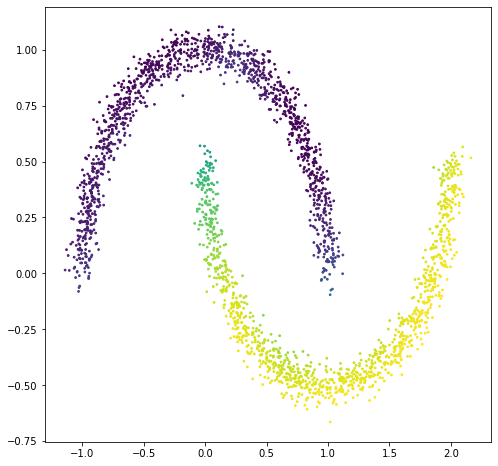

In [4]:
plt.figure(figsize = (8, 8))
plt.scatter(
    X_test[:, 0],
    X_test[:, 1],
    c = clf(X_test).numpy(),
    cmap = 'viridis',
    s = 3,
)
plt.show()

In [5]:
%%time
@tf.function
def IG_1d_clf(x, model, steps = 32, baseline = None):
    if type(baseline) == type(None):
        baseline = tf.zeros_like(x)
    delta = (x - baseline) / steps
    alphas = tf.cast(tf.linspace(0, steps, steps), delta.dtype)
    inputs = delta[tf.newaxis] * alphas[:, tf.newaxis] + baseline

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        res = clf (inputs)
    grad = tape.gradient(res, inputs)
    return tf.reduce_sum(grad, 0)

igx = tf.stack([
    IG_1d_clf(x, clf, steps = 64)
    for x in X
])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function IG_1d_clf at 0x182cffc10>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function IG_1d_clf at 0x182cffc10>. Note that functions defined in certain environments, like the interactive Python shell do not ex

In [6]:
Z = tf.stack([
    (x, y)
    for x in tf.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    for y in tf.linspace(X[:, 1].min(), X[:, 1].max(), 100)
])
Z.shape

TensorShape([10000, 2])

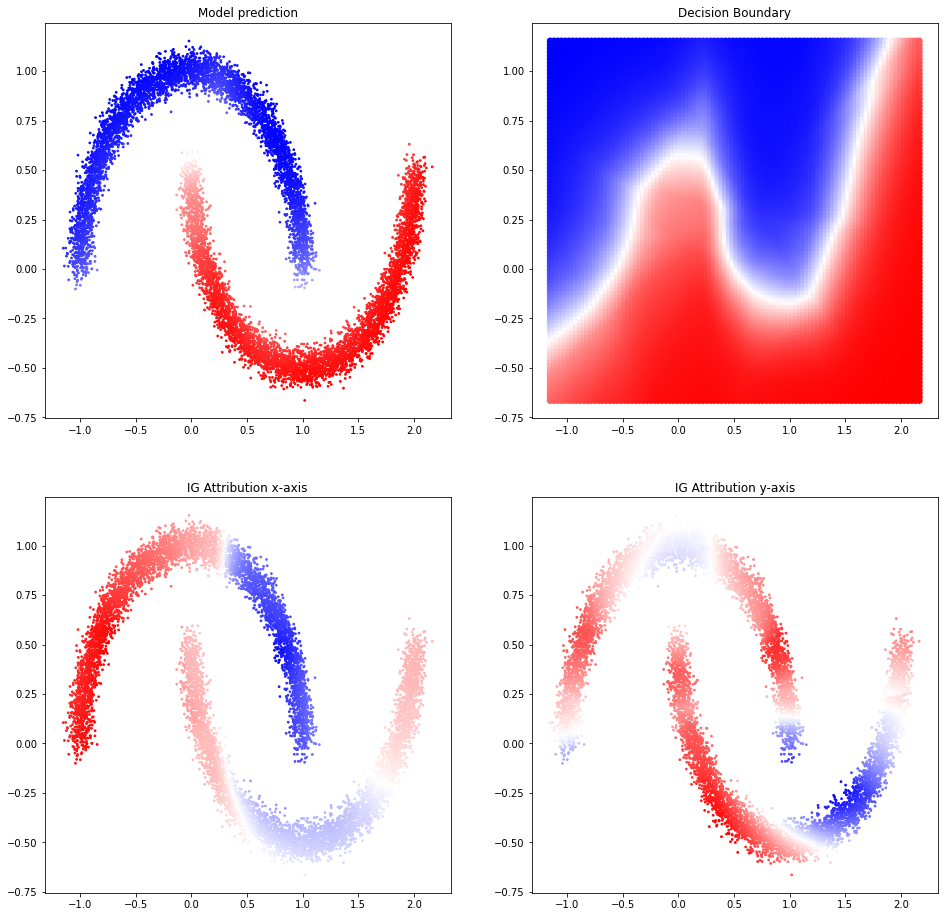

In [7]:
plt.figure(figsize = (16, 16))
R = clf(X)
W = clf(Z)
plt.subplot(221)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = R,
    s = 3,
    cmap = 'bwr'
)
plt.title('Model prediction')
plt.subplot(222)
plt.scatter(
    Z[:, 0],
    Z[:, 1],
    c = W,
    cmap = 'bwr'
)
plt.title('Decision Boundary')
plt.subplot(223)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = igx[:, 0],
    s = 3,
    cmap = 'bwr'
)
plt.title('IG Attribution x-axis')
plt.subplot(224)
plt.scatter(
    X[:, 0],
    X[:, 1],
    c = igx[:, 1],
    s = 3,
    cmap = 'bwr'
)
plt.title('IG Attribution y-axis')
plt.show()

In [8]:
X, Y = make_classification(
    n_samples     = 10000,
    n_features    = 20,
    n_informative = 5,
    n_redundant   = 5,
    n_classes     = 2,
    shuffle       = False
)

clf = tfk.Sequential([
    tfkl.InputLayer(X.shape[1]),
    tfkl.Dense(20),
    tfkl.BatchNormalization(),
    tfkl.Lambda(tf.nn.relu),
    tfkl.Dense(1, activation = 'sigmoid')
])
clf.compile(
    loss = 'binary_crossentropy',
    metrics = [tfk.metrics.AUC()],
    optimizer = 'adam'
)
hist = clf.fit(
    X, Y,
    epochs = 10,
    batch_size = 256,
    validation_split = 0.33
)
res = clf.evaluate(X, Y)

Epoch 1/10
27/27 [==============================] - 1s 9ms/step - loss: 0.5802 - auc_1: 0.7815 - val_loss: 0.6971 - val_auc_1: 0.6360
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.4853 - auc_1: 0.8502 - val_loss: 0.7423 - val_auc_1: 0.6742
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.4280 - auc_1: 0.8853 - val_loss: 0.7869 - val_auc_1: 0.6991
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.3900 - auc_1: 0.9075 - val_loss: 0.8276 - val_auc_1: 0.7189
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 0.3609 - auc_1: 0.9233 - val_loss: 0.8618 - val_auc_1: 0.7346
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 0.3358 - auc_1: 0.9354 - val_loss: 0.8937 - val_auc_1: 0.7484
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 0.3167 - auc_1: 0.9443 - val_loss: 0.9170 - val_auc_1: 0.7626
Epoch 8/10
27/27 [==============================] - 0s 2ms/ste

In [9]:
%%time
igx = tf.stack([
    IG_1d_clf(x, clf, steps = 128)
    for x in X
])

CPU times: user 2.92 s, sys: 231 ms, total: 3.15 s
Wall time: 2.73 s


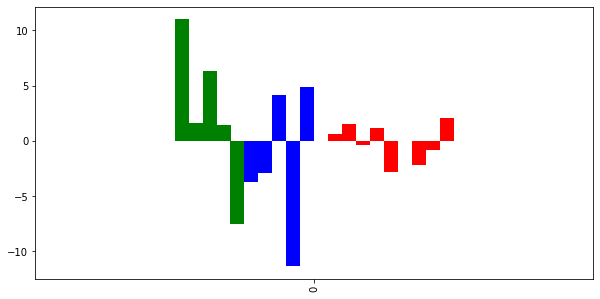

In [10]:
pd.DataFrame(tf.reduce_mean(igx, 0).numpy()).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.show()

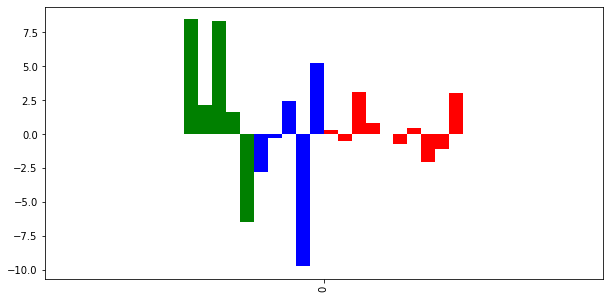

In [11]:
pd.DataFrame(igx[0].numpy()).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.show()

In [12]:
%%time

x         = X[1]
fps_base  = 2
dims      = tf.shape(x)[-1]

indices  = tf.range(dims)
stepped  = tf.zeros_like(x)
baseline = tf.random.normal(shape = x.shape, dtype = x.dtype)#tf.zeros_like(x)
grads    = tf.zeros_like(x)
steps  = 32
fps    = fps_base
delta  = (x - baseline) / steps

inputs = baseline

# Loop body
while tf.reduce_any(stepped < steps):
    
    # There is a bug that occurs if a single dimension "remains"
    # That is, all steps have been taken along each dimension except one
    # Then we will still take additional steps along some dimension (a bug)
    # This fixes that
    fps = tf.reduce_min([
        fps_base,
        tf.reduce_sum(
            tf.cast(
                stepped < steps,
                tf.int32
            )
        )
    ])
    
    # Compute gradient
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        res = clf (inputs[tf.newaxis])
    grad = tape.gradient(res, inputs)

    # Find indices of lowest absolute gradients
    # If sufficient steps have already been taken in dimension-direction,
    #   set those gradients to maximum
    grad = tf.where(
        stepped < steps,
        grad,
        tf.reduce_max(tf.abs(grad)) + 1
    )
    lowest = tf.argsort(tf.abs(grad))[:fps]

    # Construct masking vector from (remaining) indices vs minimum gradient
    step_towards = tf.reduce_any(lowest[:, tf.newaxis] == indices[tf.newaxis], 0)

    # Will simply be added to "stepped" (per-dim counter)
    mask_step = tf.cast(
        step_towards,
        stepped.dtype
    )

    # Will be added to cumulative input
    mask_input = tf.cast(
        step_towards, 
        x.dtype
    ) * delta

    # Increment various
    stepped = stepped + mask_step
    inputs  = inputs  + mask_input
    grads   = grads   + grad

CPU times: user 1.05 s, sys: 4.63 ms, total: 1.05 s
Wall time: 1.05 s


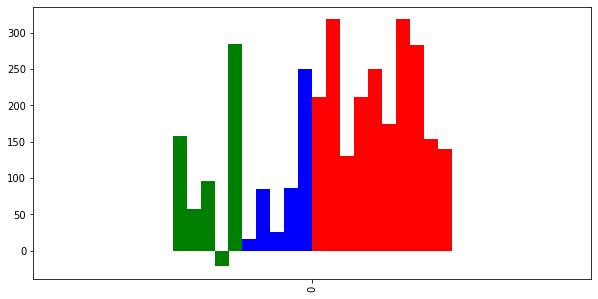

In [13]:
pd.DataFrame(grads.numpy()).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.show()

In [14]:
from guided_ig import unbounded_guided_ig, anchored_guided_ig

In [15]:
clf

In [16]:
def grad_func(x):
    x = tf.constant(x)[tf.newaxis]
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = clf(x)
    return tape.gradient(y, x).numpy().flatten()

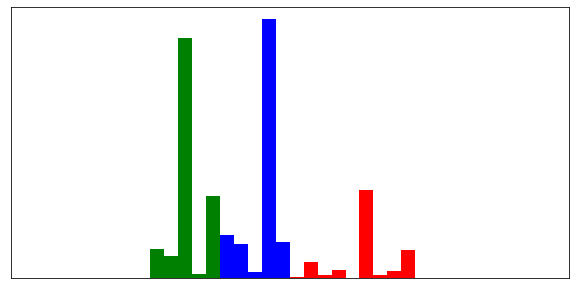

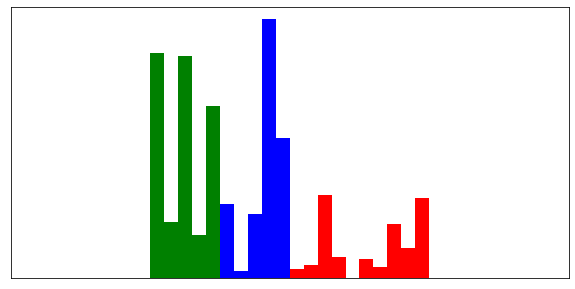

CPU times: user 431 ms, sys: 6.72 ms, total: 438 ms
Wall time: 435 ms


In [17]:
%%time

x = X[0]
baseline = np.zeros_like(x)
baseline

att = unbounded_guided_ig(x, baseline, 128, grad_func, 0.1)

pd.DataFrame(np.abs(att)).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.yticks([])
plt.xticks([])
plt.show()

pd.DataFrame(np.abs(igx[0].numpy())).T.plot.bar(
    figsize = (10, 5),
    legend = False,
    color = [
        *( 5 * ['g']),
        *( 5 * ['b']),
        *(10 * ['r'])
    ]
)
plt.yticks([])
plt.xticks([])
plt.show()

In [18]:
rnd100 = np.random.choice(np.arange(10000), replace = False, size = 100)

In [19]:
%%time
atts = np.array([unbounded_guided_ig(x, baseline, 128, grad_func, 0.1) for x in X[rnd100]])

CPU times: user 24 s, sys: 23.8 ms, total: 24 s
Wall time: 24 s


In [20]:
%%time
atts2 = np.array([anchored_guided_ig(x, baseline, grad_func, 128, 0.1, 20) for x in X[rnd100]])

CPU times: user 26.7 s, sys: 64.4 ms, total: 26.8 s
Wall time: 26.8 s


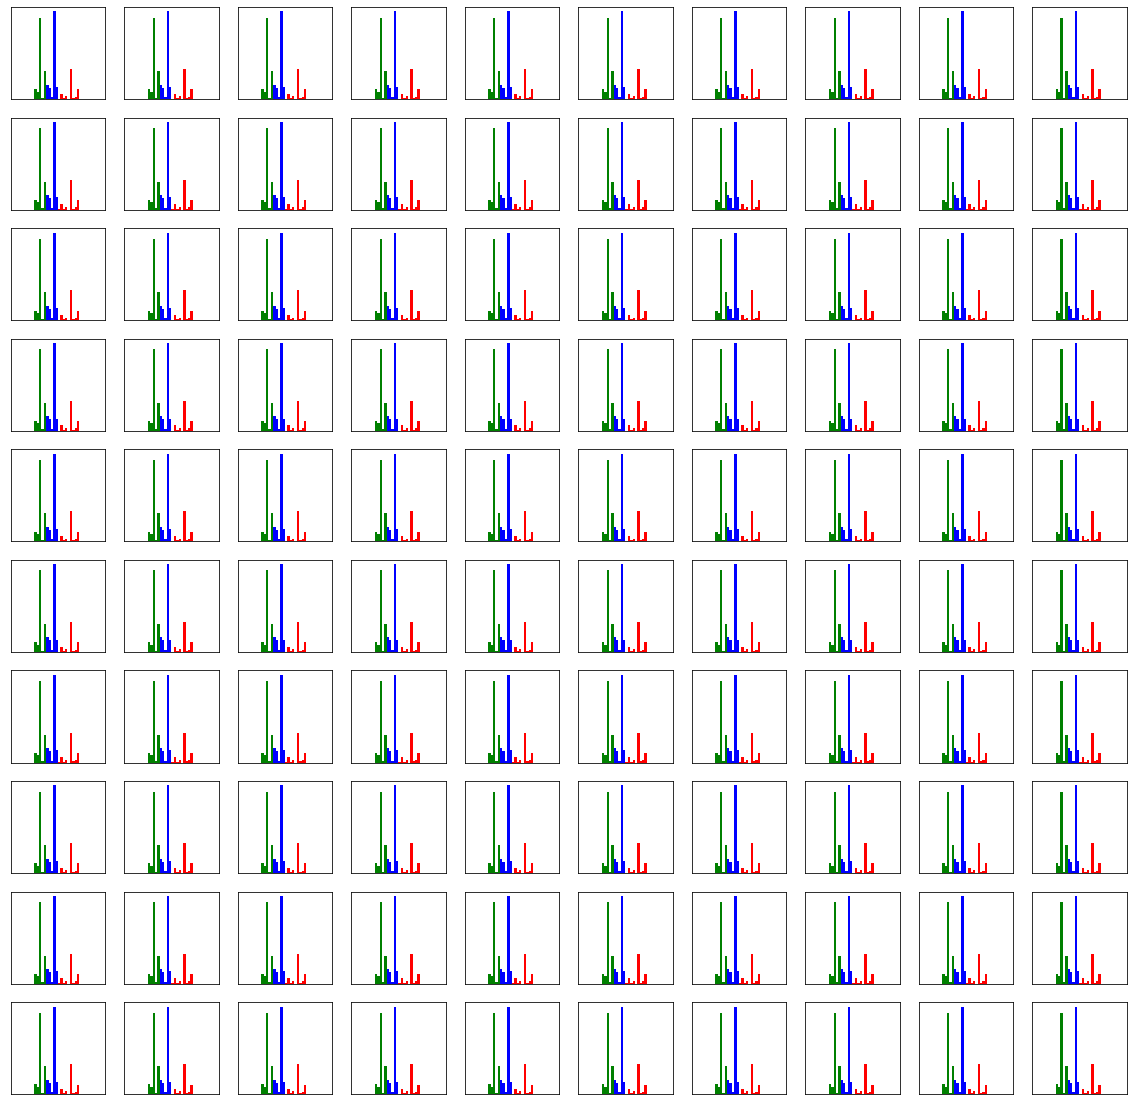

In [21]:
fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20, 20))
axes = axes.flatten()
for a, ax in zip(atts, axes):
    pd.DataFrame(np.abs(att)).T.plot.bar(
        ax = ax,
        legend = False,
        color = [
            *( 5 * ['g']),
            *( 5 * ['b']),
            *(10 * ['r'])
        ]
    )
    ax.set_yticks([])
    ax.set_xticks([])
plt.show()

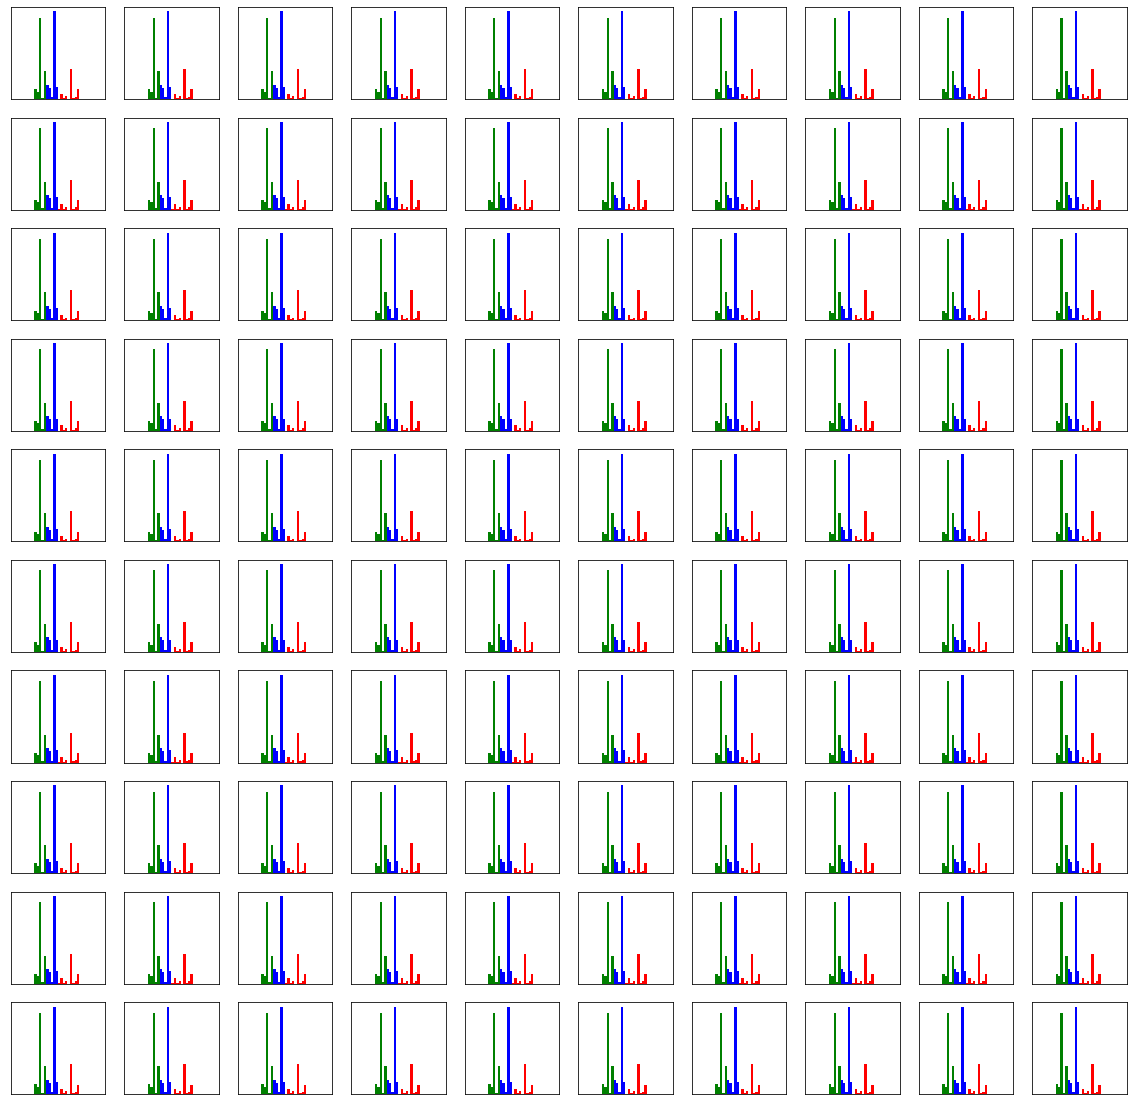

In [22]:
fig, axes = plt.subplots(nrows = 10, ncols = 10, figsize = (20, 20))
axes = axes.flatten()
for a, ax in zip(atts2, axes):
    pd.DataFrame(np.abs(att)).T.plot.bar(
        ax = ax,
        legend = False,
        color = [
            *( 5 * ['g']),
            *( 5 * ['b']),
            *(10 * ['r'])
        ]
    )
    ax.set_yticks([])
    ax.set_xticks([])
plt.show()

In [23]:
from tensorflow.keras.datasets.mnist import load_data

In [24]:
(X_train, Y_train), (X_test, Y_test) = load_data()
X_train = X_train[..., np.newaxis] / 255
X_test  = X_test [..., np.newaxis] / 255
Y_train = tf.one_hot(Y_train, 10).numpy()
Y_test  = tf.one_hot(Y_test , 10).numpy()
X_train.shape, Y_train.shape

((60000, 28, 28, 1), (60000, 10))

In [25]:
model = tfk.Sequential([
    tfkl.InputLayer(X_train.shape[1:]),
    tfkl.Conv2D(
        filters = 10,
        kernel_size = 3,
        strides = 3,
        padding = 'same',
        activation = 'relu'
    ),
    tfkl.MaxPooling2D(),
    tfkl.Flatten(),
    tfkl.Dense(32, activation = 'relu'),
    tfkl.BatchNormalization(),
    tfkl.Dense(10, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [tfk.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                8032      
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 8,590
Trainable params: 8,526
Non-trainable params: 64
___________________________________________________

In [26]:
hist = model.fit(X_train, Y_train, epochs = 3, validation_split = 0.1, batch_size = 128)

Epoch 1/3
422/422 [==============================] - 2s 3ms/step - loss: 0.7362 - categorical_accuracy: 0.7786 - val_loss: 0.3900 - val_categorical_accuracy: 0.9067
Epoch 2/3
422/422 [==============================] - 1s 3ms/step - loss: 0.2870 - categorical_accuracy: 0.9138 - val_loss: 0.2089 - val_categorical_accuracy: 0.9365
Epoch 3/3
422/422 [==============================] - 1s 3ms/step - loss: 0.2128 - categorical_accuracy: 0.9344 - val_loss: 0.1712 - val_categorical_accuracy: 0.9467


In [27]:
def grad_func(x):
    x = tf.constant(x)[tf.newaxis]
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x)
    return tape.gradient(y, x).numpy().reshape(x.shape[1:])
baseline = np.zeros_like(X_train[0])

In [28]:
%%time
test = X_train[rnd100]
atts = np.array([unbounded_guided_ig(x, baseline, 128, grad_func, 0.1) for x in test])
pred = [model(x[np.newaxis]).numpy() for x in test]
pred = [(p.argmax(), p.max()) for p in pred]

CPU times: user 36.5 s, sys: 580 ms, total: 37.1 s
Wall time: 37.2 s


In [29]:
%%time
def IG_2d_clf(x, clf, steps = 32, baseline = None):
    if type(baseline) == type(None):
        baseline = tf.zeros_like(x)
    delta = (x - baseline) / steps
    alphas = tf.cast(tf.linspace(0, steps, steps), delta.dtype)
    inputs = delta[tf.newaxis] * alphas[:, tf.newaxis, tf.newaxis, tf.newaxis] + baseline

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        res = clf (inputs)
    grad = tape.gradient(res, inputs)
    return tf.reduce_sum(grad, 0)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


In [30]:
%%time
atts2 = [IG_2d_clf(x, model, 128).numpy() for x in X_train[rnd100]]

CPU times: user 1.1 s, sys: 199 ms, total: 1.3 s
Wall time: 770 ms


In [31]:
%%time
atts_pca = [IG_2d_clf(x, model, 128).numpy() for x in X_train[np.random.choice(np.arange(60000), replace = False, size = 5000)]]

CPU times: user 55.6 s, sys: 10.4 s, total: 1min 5s
Wall time: 39.1 s


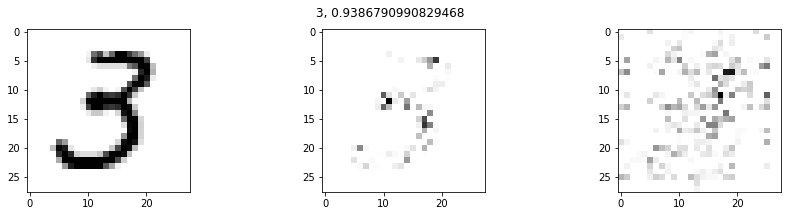

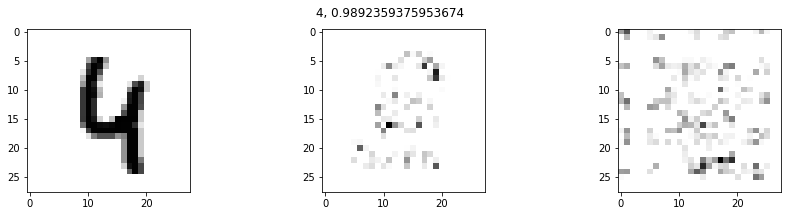

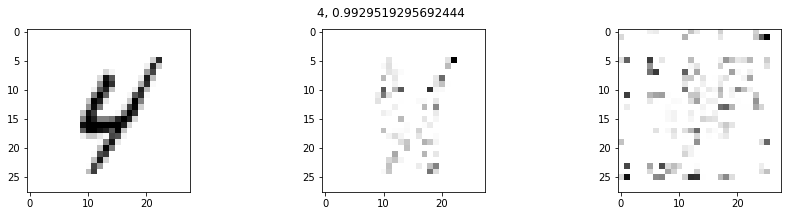

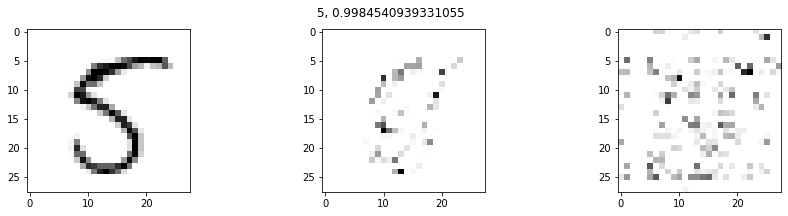

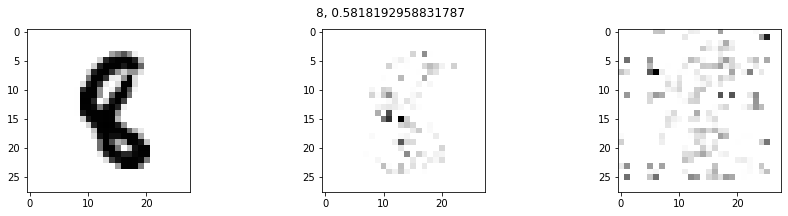

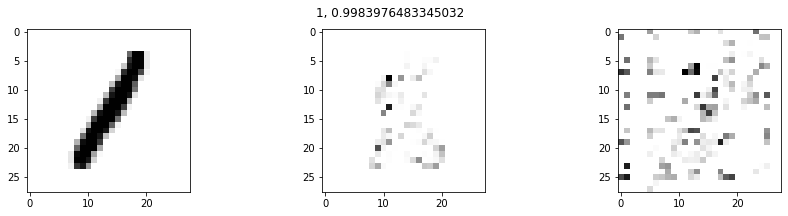

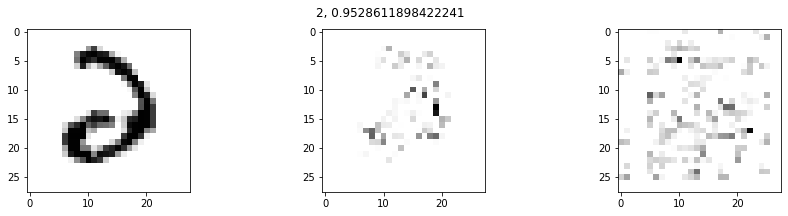

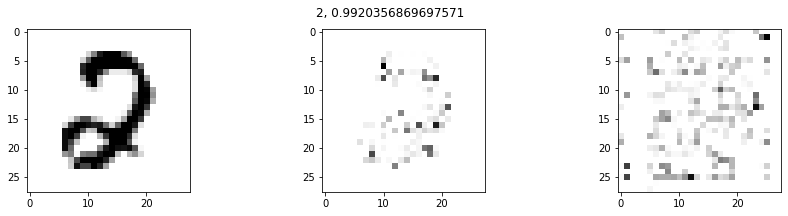

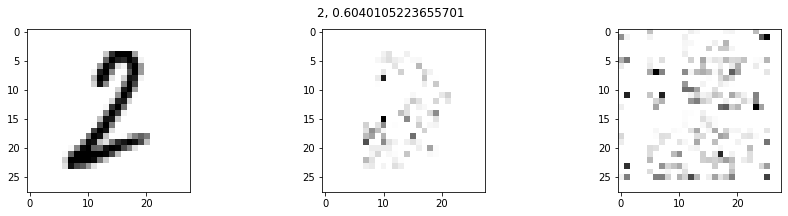

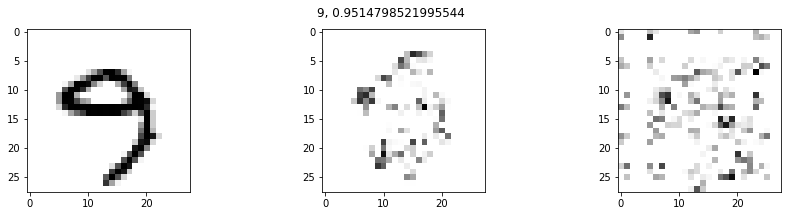

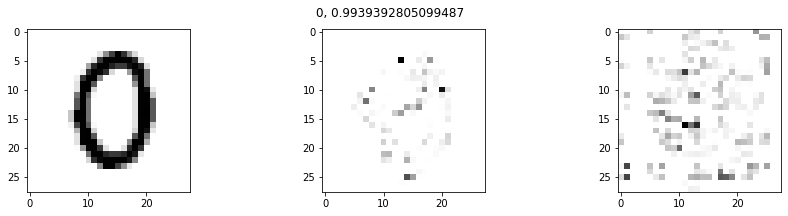

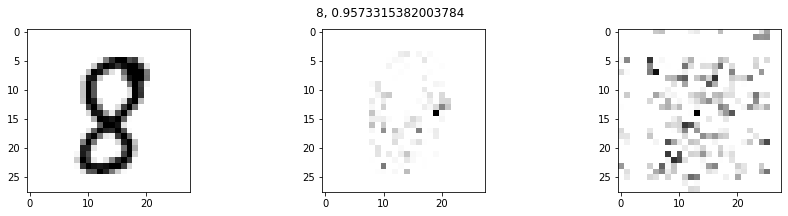

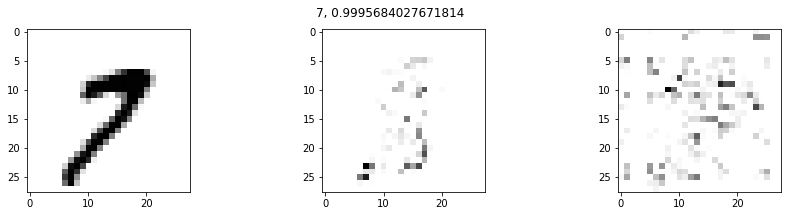

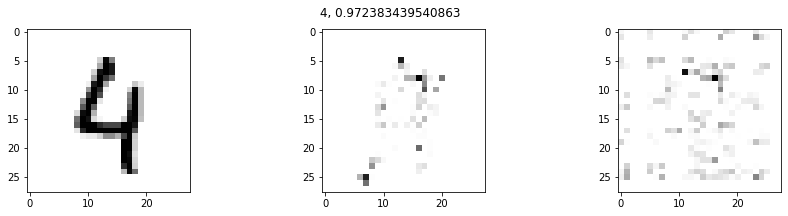

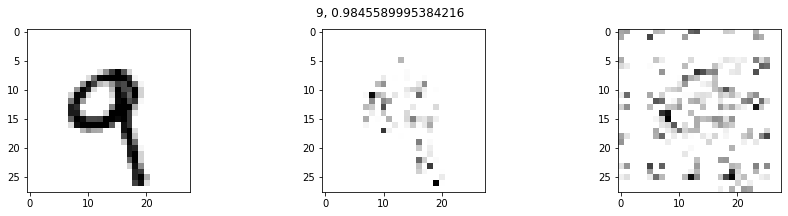

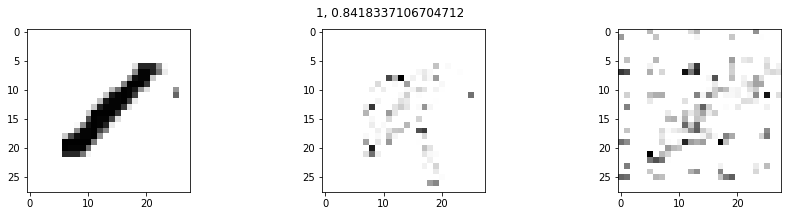

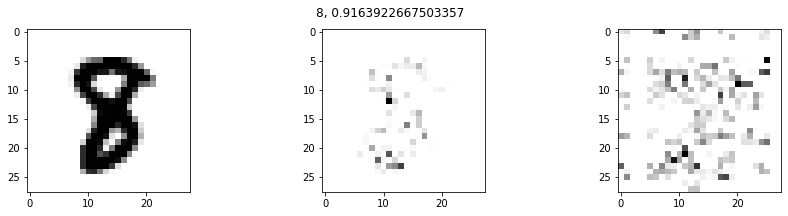

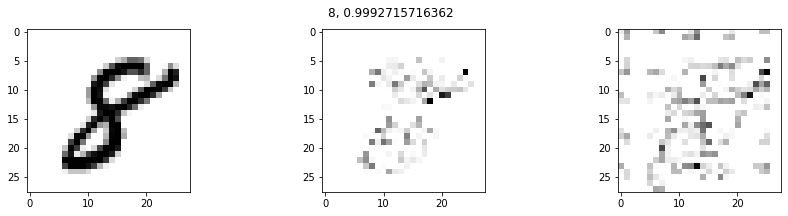

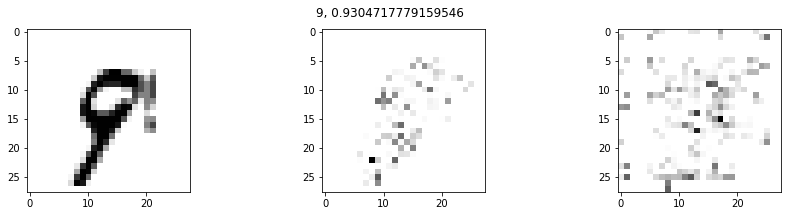

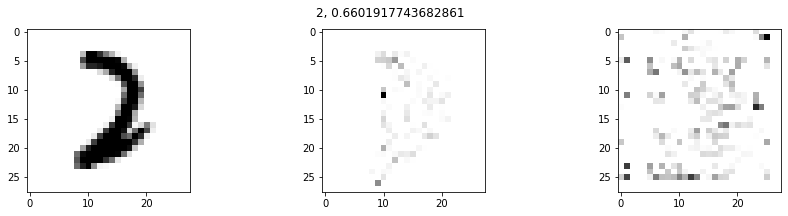

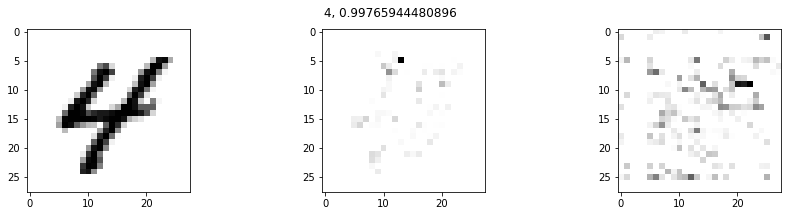

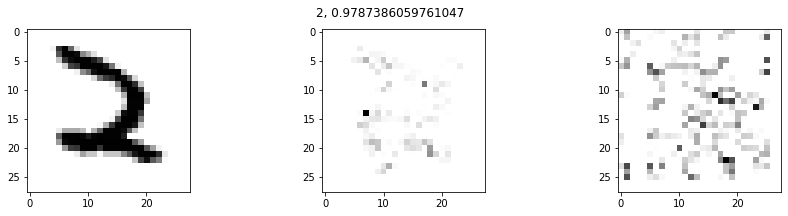

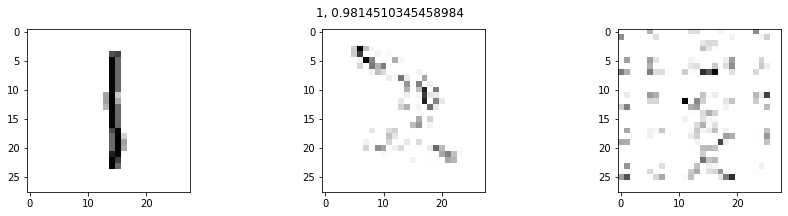

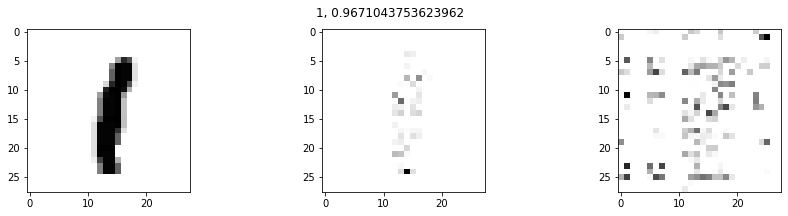

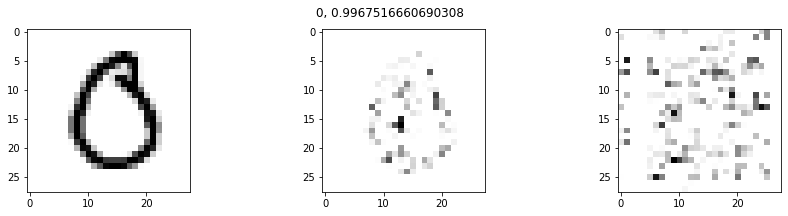

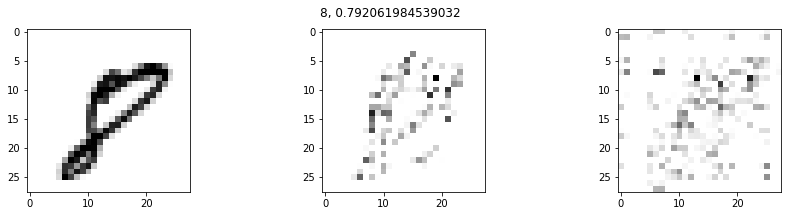

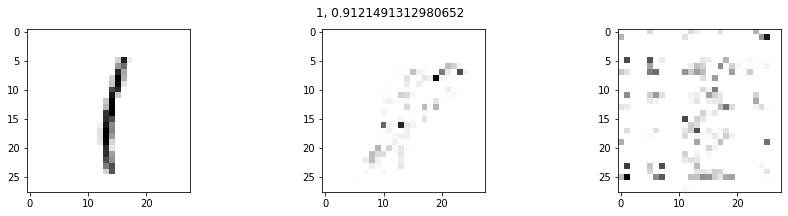

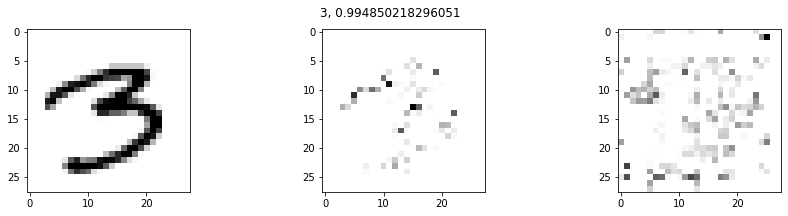

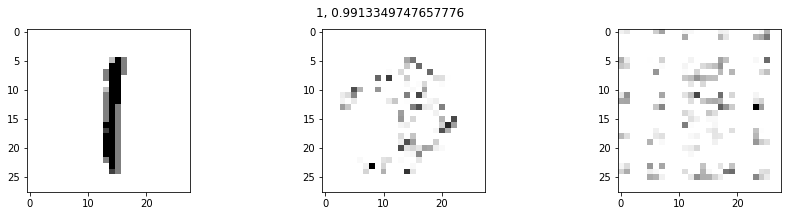

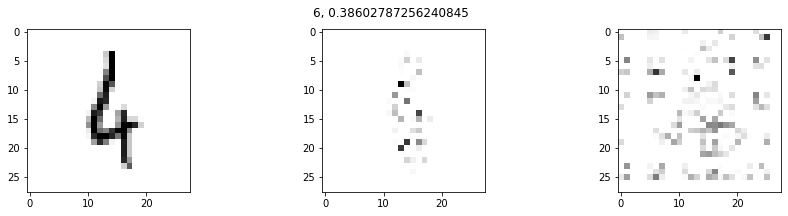

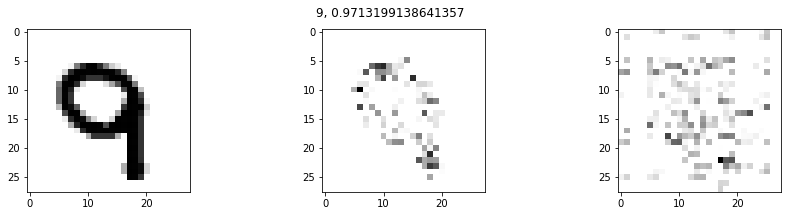

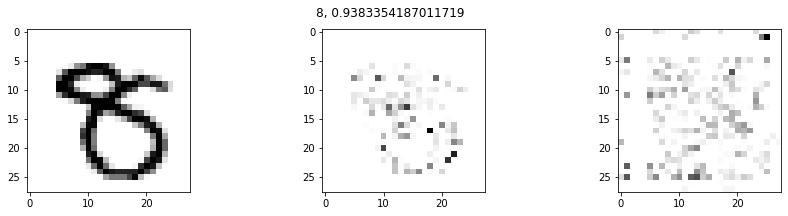

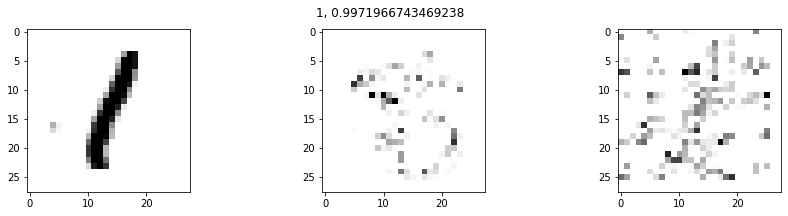

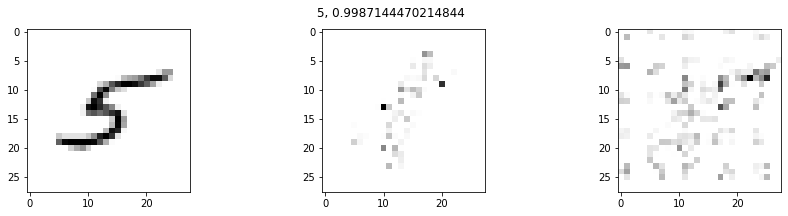

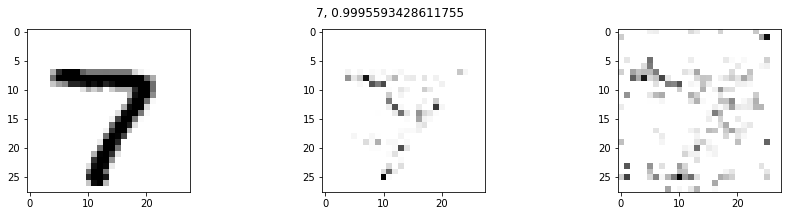

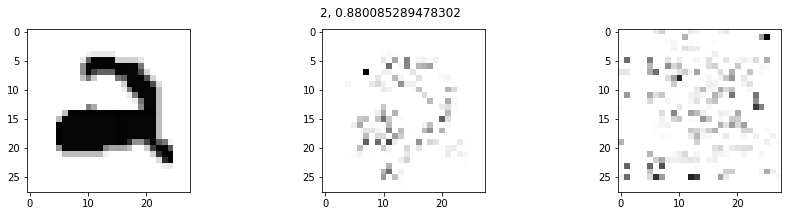

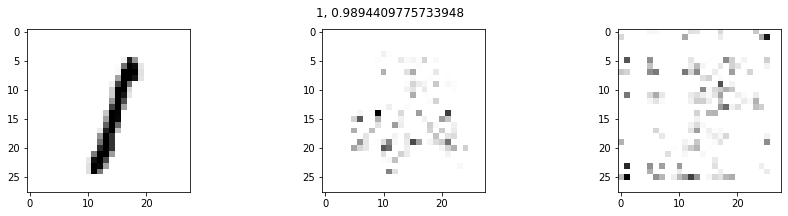

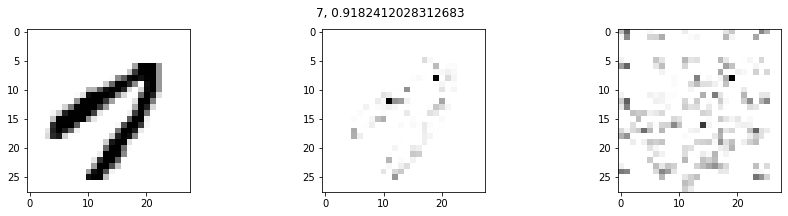

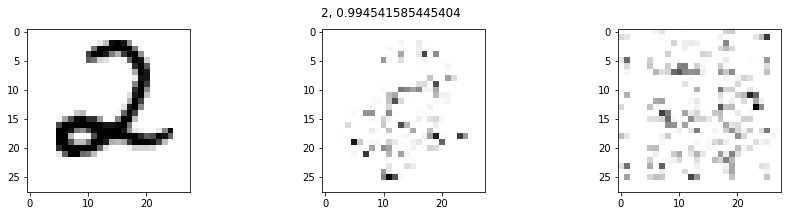

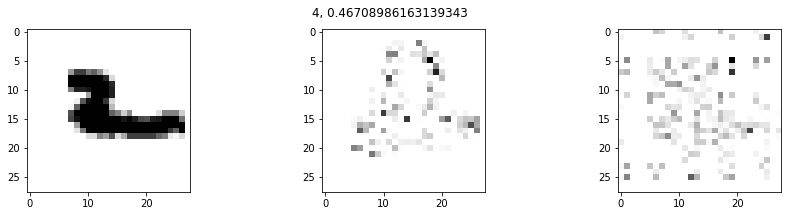

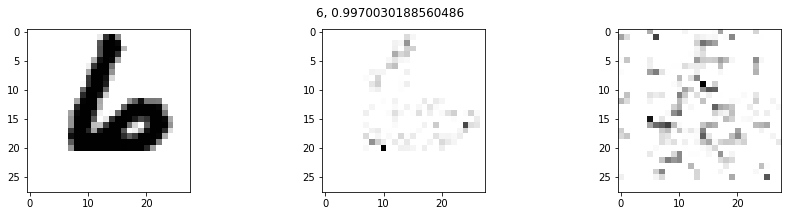

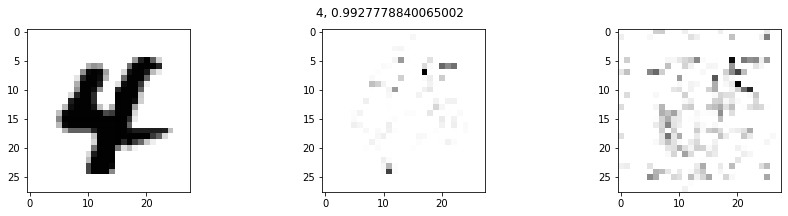

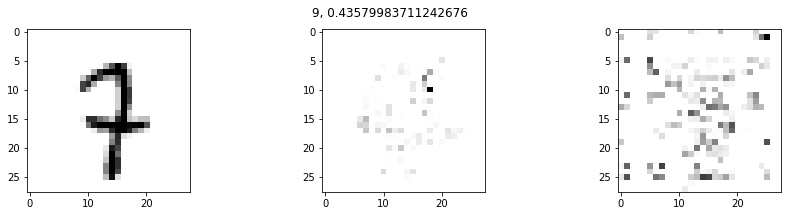

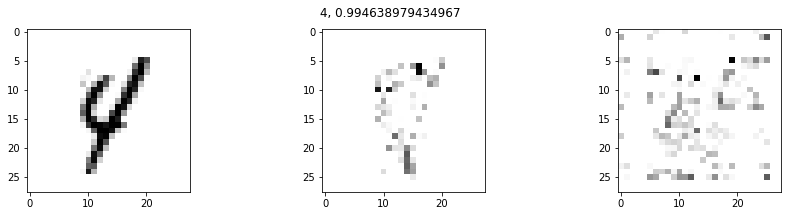

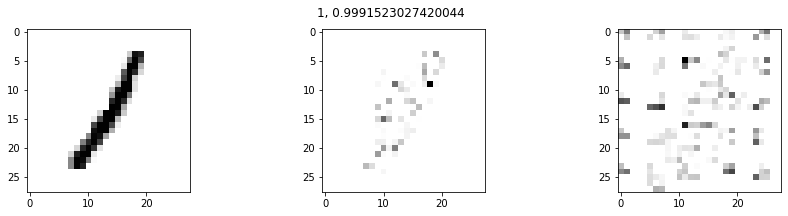

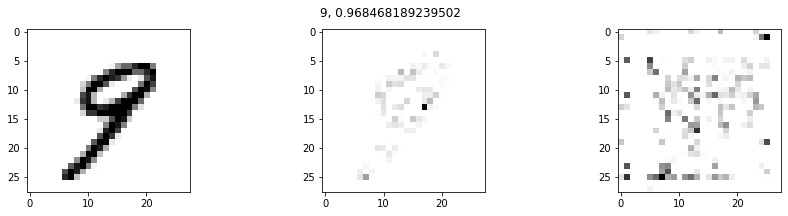

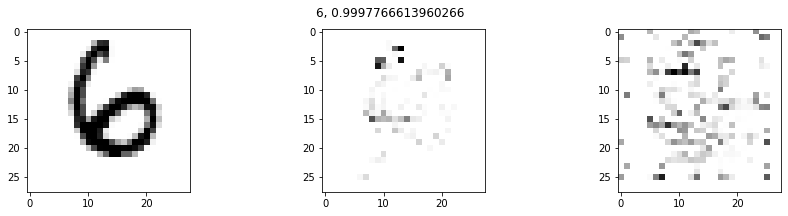

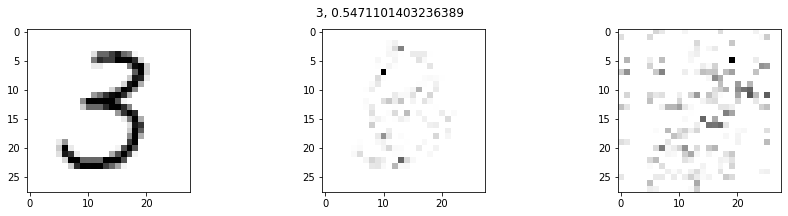

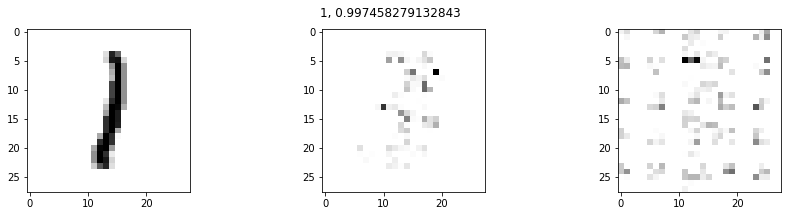

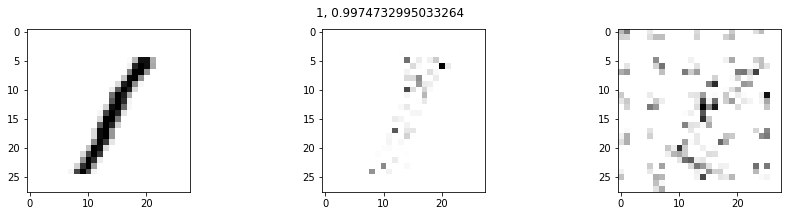

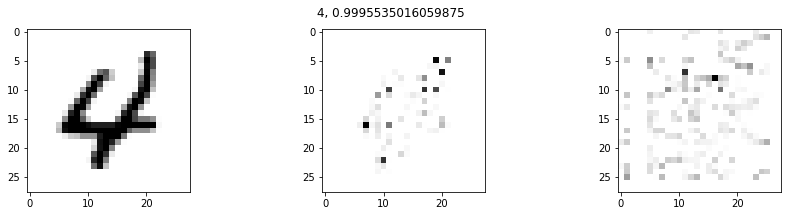

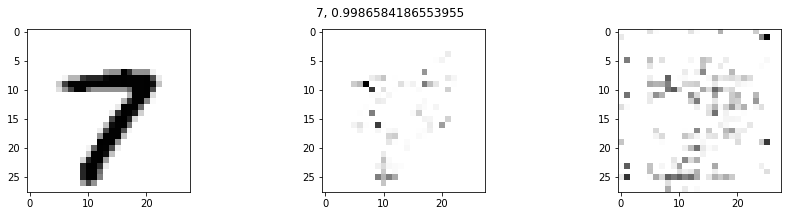

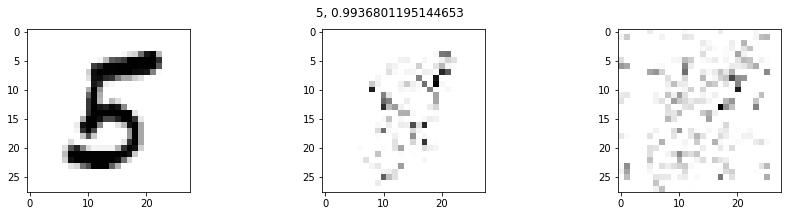

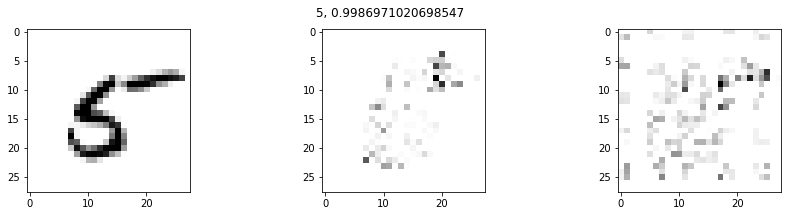

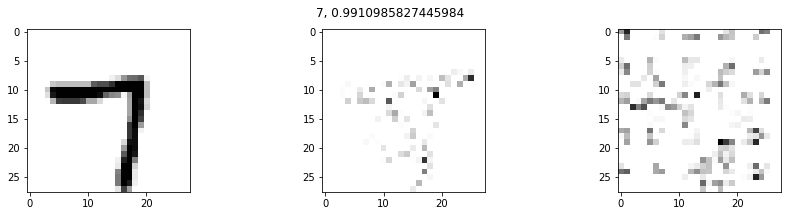

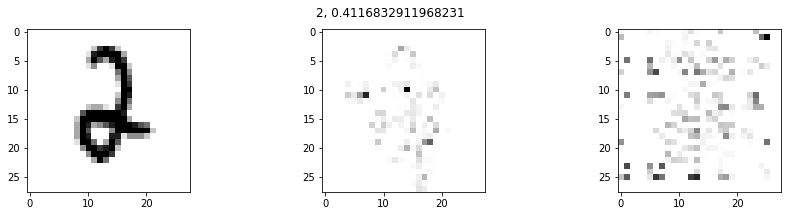

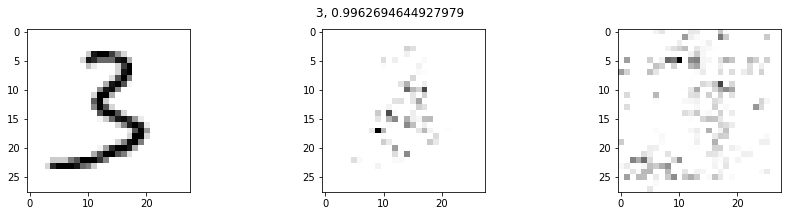

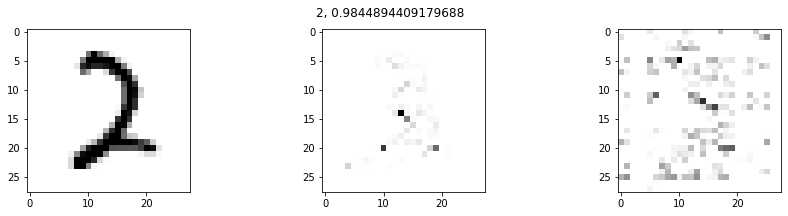

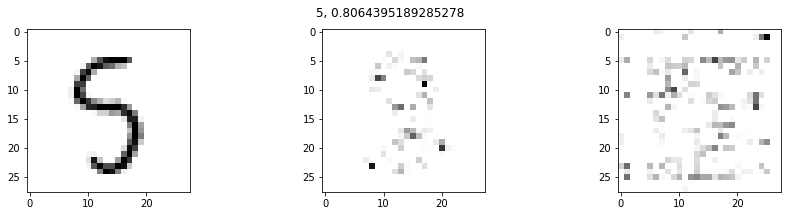

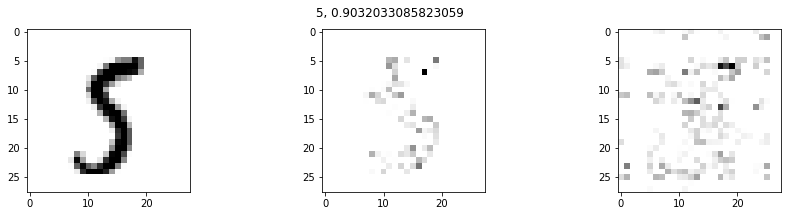

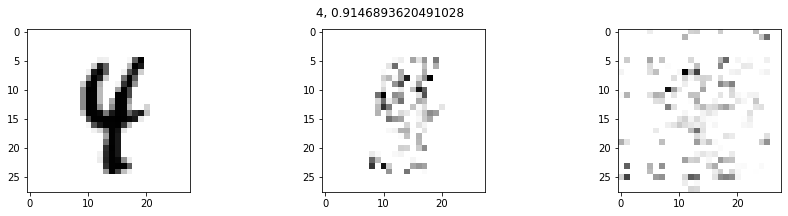

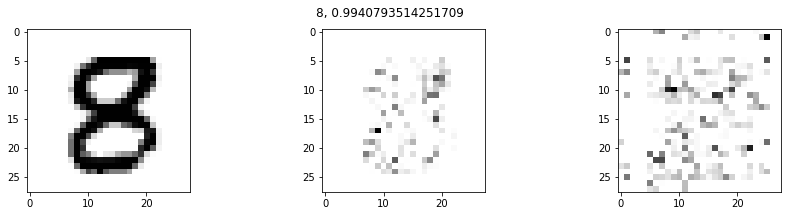

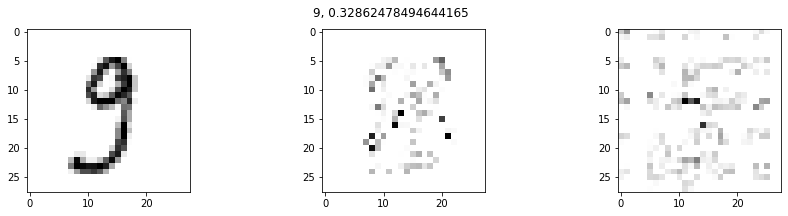

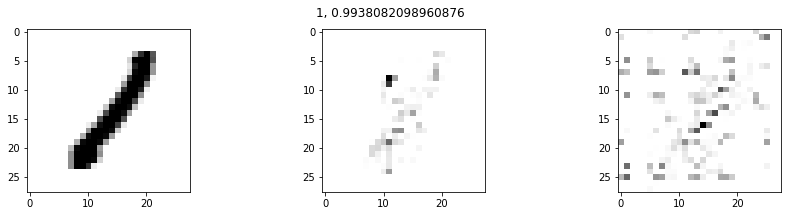

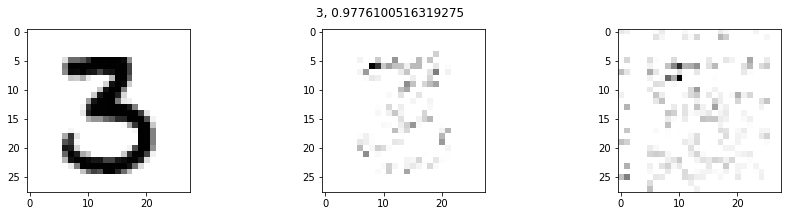

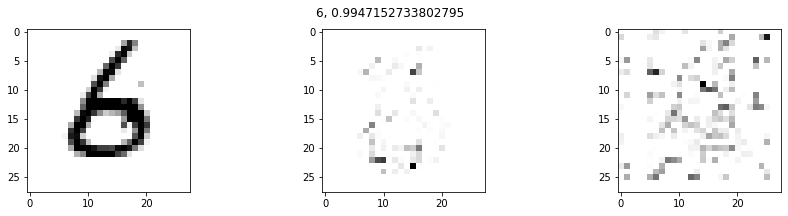

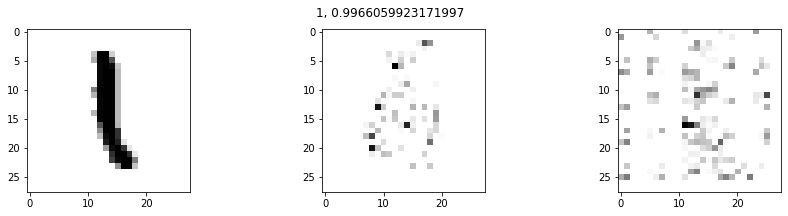

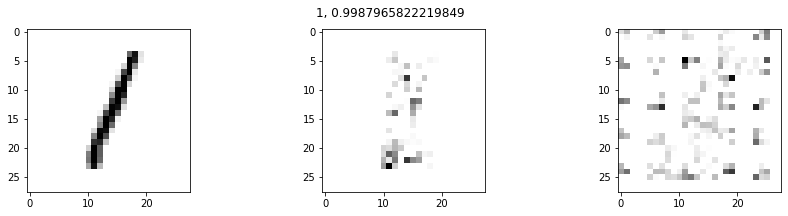

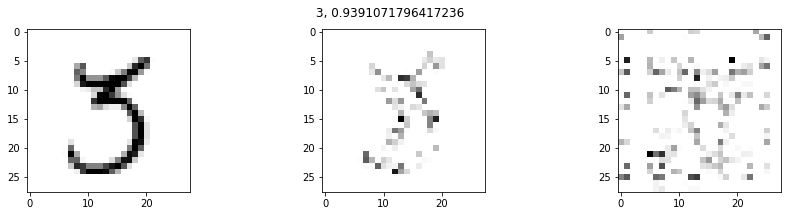

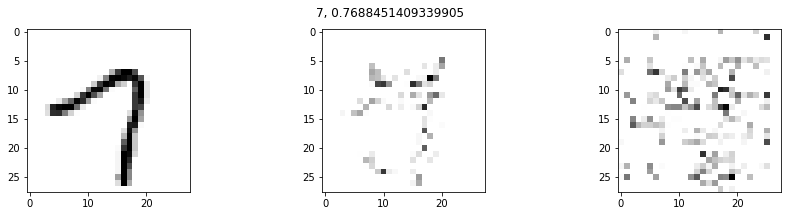

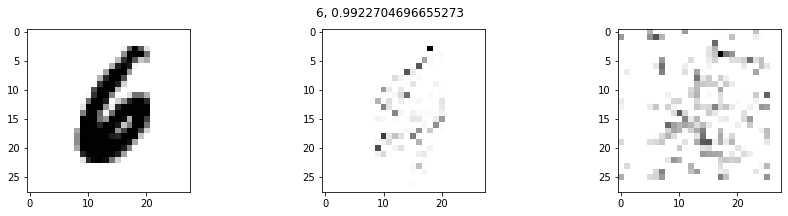

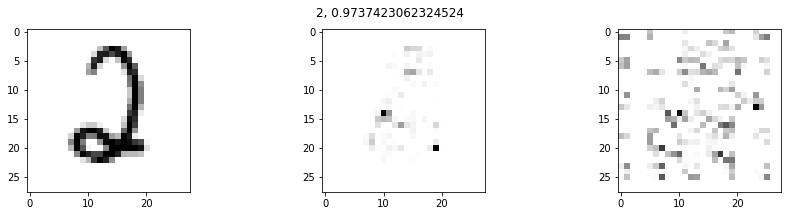

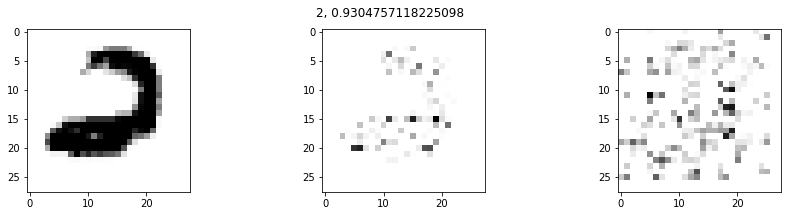

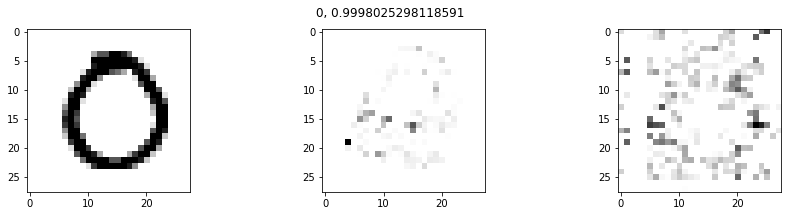

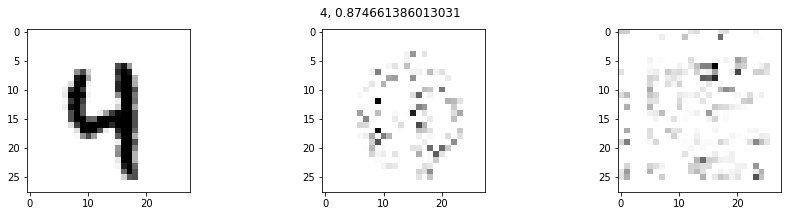

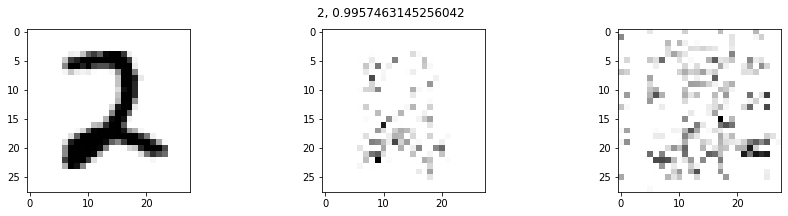

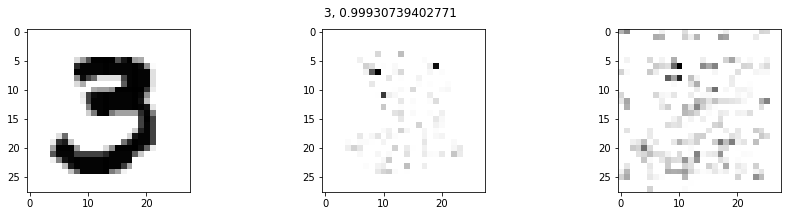

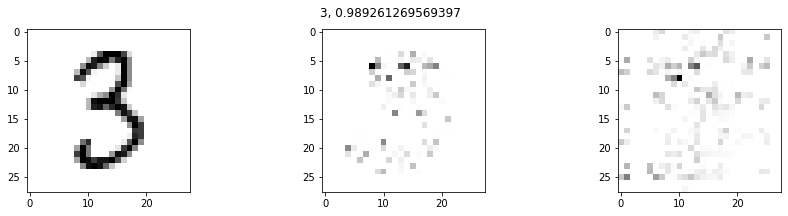

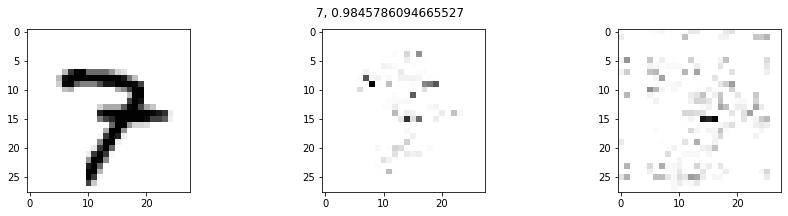

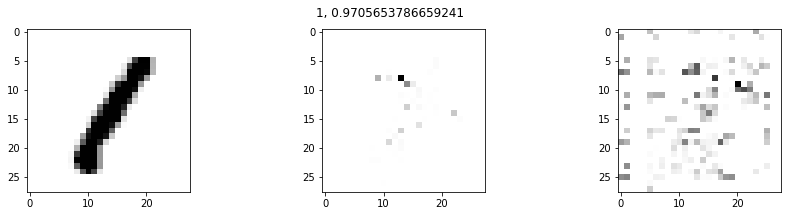

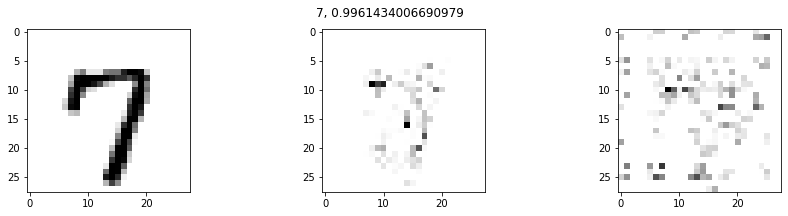

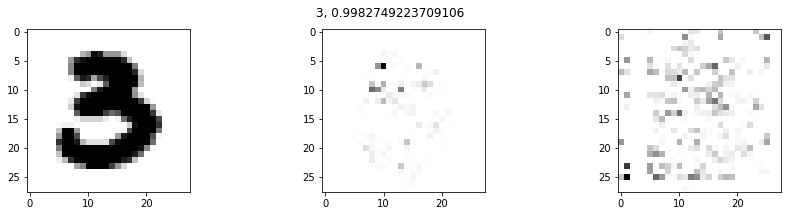

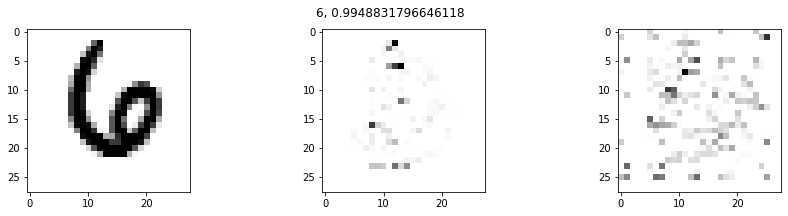

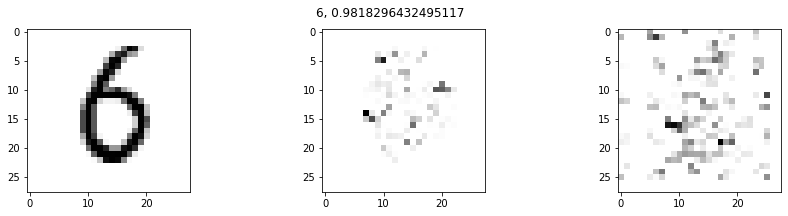

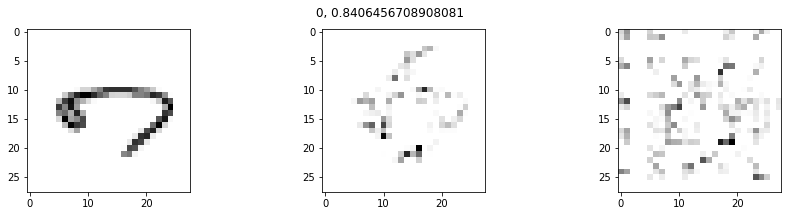

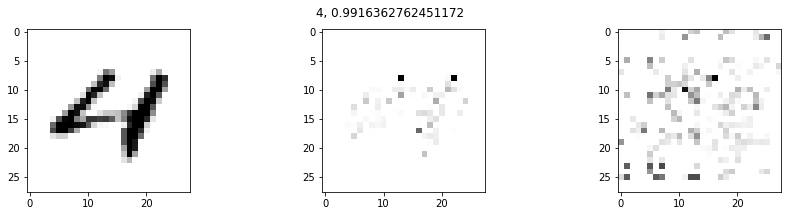

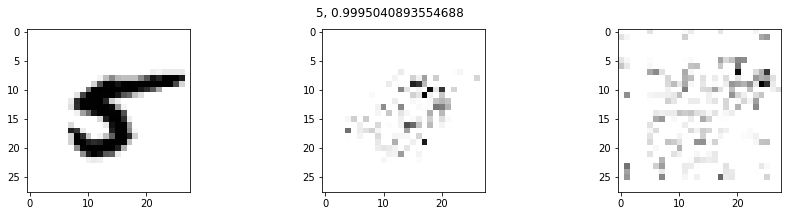

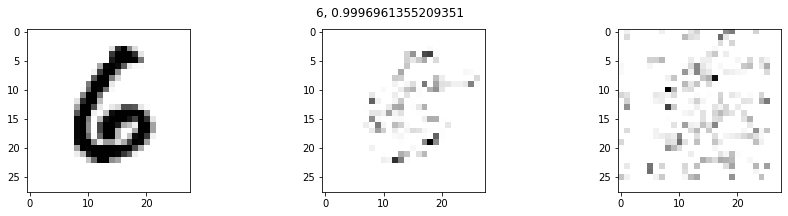

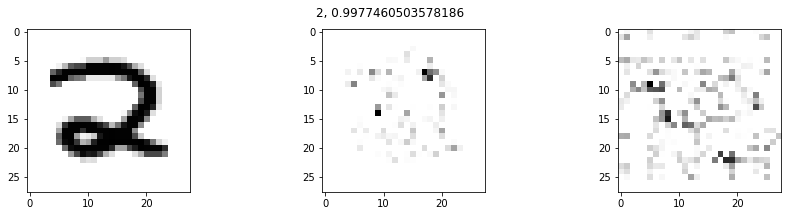

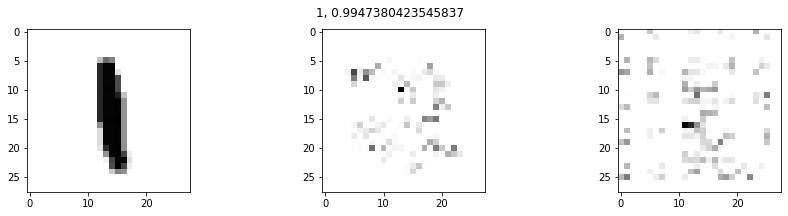

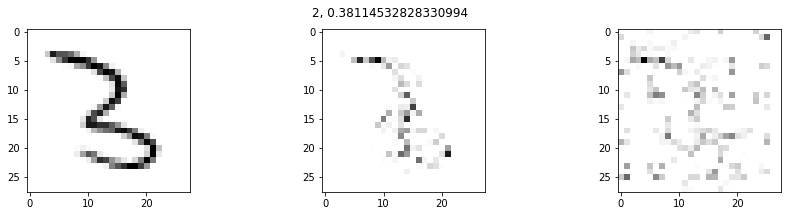

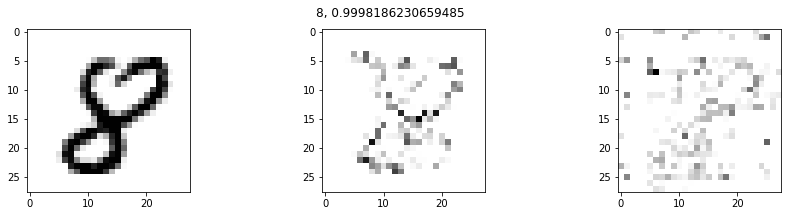

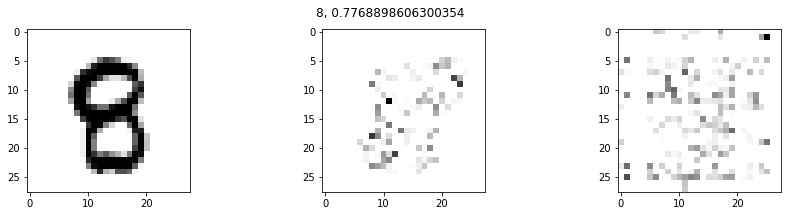

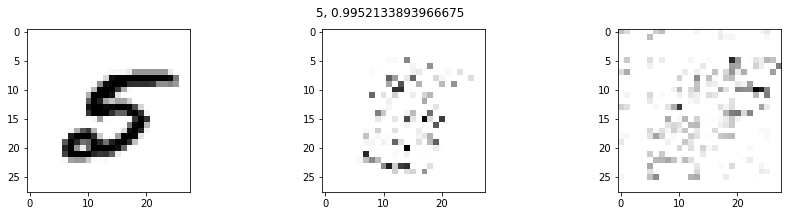

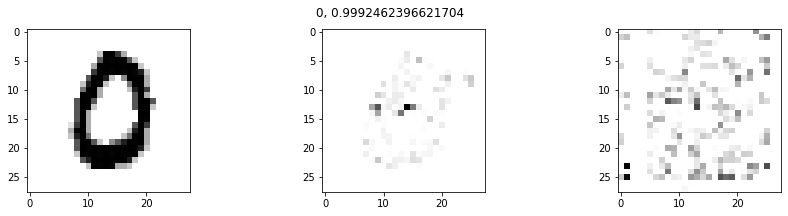

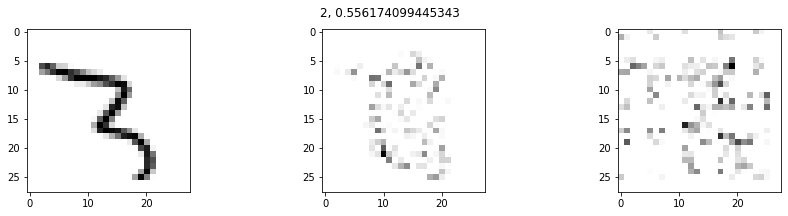

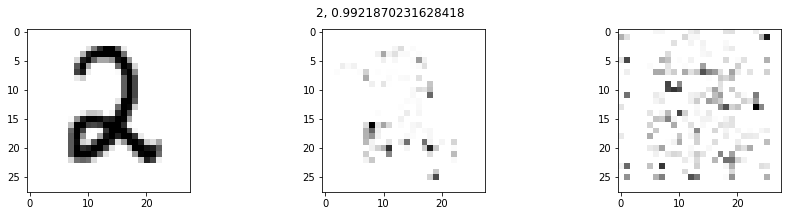

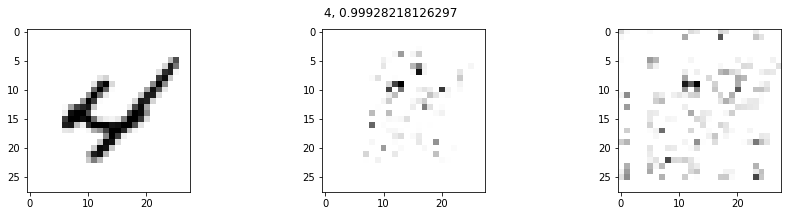

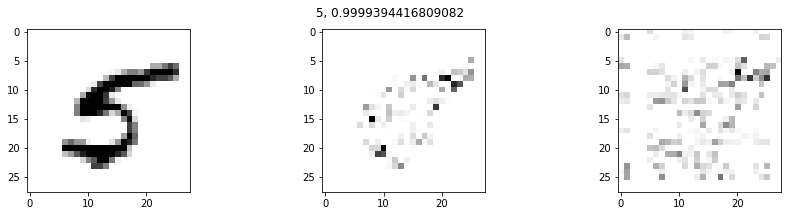

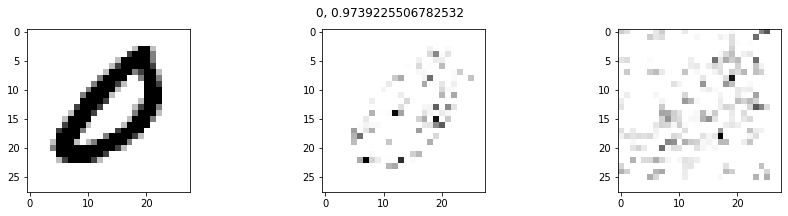

In [32]:
for (pmax, pval), x, att1, att2 in zip(pred, test, atts, atts2):
    x = np.squeeze(x)
    plt.figure(figsize = (15, 3))
    plt.suptitle(f'{pmax}, {pval}')
    plt.subplot(131)
    plt.imshow(
        x,
        cmap = 'gist_yarg',
        interpolation = 'none'
    )
    pval = round(pval, 2)
    plt.subplot(132)
    plt.imshow(
        np.squeeze(att1),
        cmap = 'gist_yarg',
        interpolation = 'none',
        vmin = 0
    )
    plt.subplot(133)
    plt.imshow(
        np.squeeze(att2),
        cmap = 'gist_yarg',
        interpolation = 'none',
        vmin = 0
    )
    plt.show()